# Behavioral Incident Prediction Using XG Boost

This notebook demonstrates a proof-of-concept model for predicting behavioral incidents based on structured client compliance data. Using a synthetic dataset generated to reflect the distribution and properties of real-world data (with no PHI), I train an XGBoost classifier and evaluate performance given the rare occurence of incidents.

The goal is to identify early warning signals and support proactive intervention strategies.


## Problem Statement

Can we use recent client activity data to predict the likelihood of a behavioral incident occurring the next day?

This model aims to support frontline staff in prioritizing high-risk cases by highlighting potential escalations in behavioral trends.


## Dataset Overview

The dataset includes 13 compliance-related features, 4 affect-related features, 17 strength-related features, and one feature for boundaries and one for predictability.  Boundaries and predictability are thought to behave differently than ordinary compliance and strength related features. Data has been generated to simulate daily entries per client.

I also include engineered features such as:

- Rolling 3-day mean compliance index
- Day-to-day delta in index score
- Incident flags for next-day or 3-day windows

Note: All data is synthetic and intended for demonstration purposes only.


## Class Imbalance

Behavioral incidents are rare events. This is the primary motivation behind selecting the XGBoost model.  XGBoost builds decision trees sequentially rather than in parallel like Random Forest, which can reduce bias through iterative refinement. To further address class imbalance, I apply SMOTE (Synthetic Minority Over-sampling Technique) to upsample positive cases during training.

This helps prevent the model from defaulting to the majority (non-incident) class.


## Model: XGBoost

I train an XG Boost with 100 trees and balanced class weights. Evaluation metrics include:

- Accuracy
- Precision / Recall
- Confusion Matrix
- Feature Importances

I also adjust the classification threshold to optimize for sensitivity (recall), as missing an incident is costlier than a false positive.

C:\Users\Will\AppData\Local\Temp\ipykernel_23520\530205289.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  incident.groupby(df['people_id']).shift(-1).fillna(False) |
C:\Users\Will\AppData\Local\Temp\ipykernel_23520\530205289.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  incident.groupby(df['people_id']).shift(-2).fillna(False) |
C:\Users\Will\AppData\Local\Temp\ipykernel_23520\530205289.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects

Accuracy: 0.66

Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.23      0.29        60
           1       0.72      0.84      0.78       140

    accuracy                           0.66       200
   macro avg       0.55      0.54      0.53       200
weighted avg       0.62      0.66      0.63       200



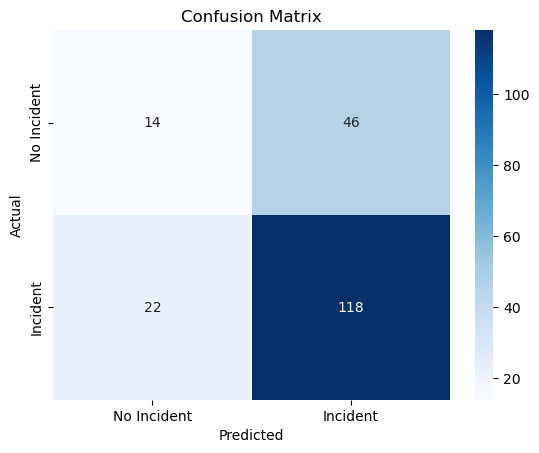

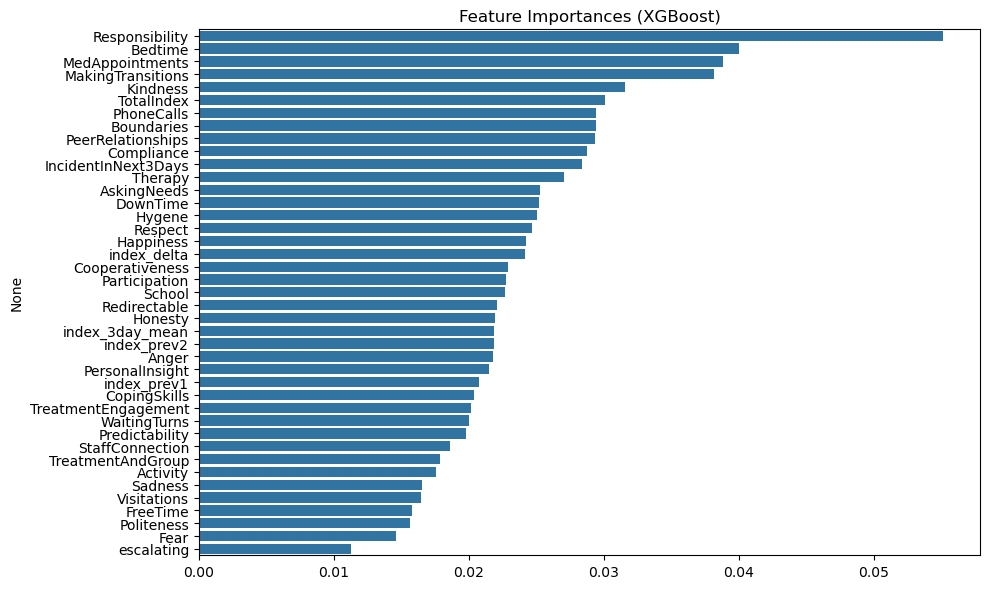

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Load your dataset
file_path = Path.cwd().parent / "Data" / "fake_structured.csv"
df = pd.read_csv(file_path)
df = df.sort_values(by=['people_id', 'actual_date'])

df['index_prev1'] = df.groupby('people_id')['TotalIndex'].shift(1)
df['index_prev2'] = df.groupby('people_id')['TotalIndex'].shift(2)

df['index_3day_mean'] = df.groupby('people_id')['TotalIndex'].rolling(3).mean().reset_index(0, drop=True)
df['index_delta'] = df['TotalIndex'] - df['index_prev1']
df['escalating'] = (df['index_delta'] > 0) & (df['index_prev1'] > df['index_prev2'])
incident = df['IncidentNextDay'].astype(bool)
df['IncidentInNext3Days'] = (
    incident.groupby(df['people_id']).shift(-1).fillna(False) |
    incident.groupby(df['people_id']).shift(-2).fillna(False) |
    incident.groupby(df['people_id']).shift(-3).fillna(False)
).astype(int)

# Prepare data
df = df.iloc[:, 6:]  # Trim off metadata
target_col = 'IncidentNextDay'
feature_cols = [col for col in df.columns if col != target_col]

X = df[feature_cols]
y = df[target_col]

smote = SMOTE(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Initialize and train XGBoost classifier
clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # Adjust for class imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

clf.fit(X_train_bal, y_train_bal)

# Predict probabilities and apply custom threshold
y_probs = clf.predict_proba(X_test)[:, 1]
y_pred_custom = (y_probs > 0.3).astype(int)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_custom))
print("\nClassification Report:\n", classification_report(y_test, y_pred_custom))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_custom)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Incident', 'Incident'],
            yticklabels=['No Incident', 'Incident'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance Plot
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

## Conclusion

This model demonstrates the feasibility of early warning prediction for behavioral incidents using structured compliance data. While based on synthetic data, the results suggest potential for deployment in decision support tools.

Future improvements could include:

- Incorporating case narratives via NLP models
- Using RNNs or Transformers to model sequential data
- Calibrating thresholds with cost-sensitive metrics

This notebook is part of a larger research effort to improve safety and outcomes in youth treatment programs.